In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

# Майнор по Анализу Данных, Группа ИАД-2
## 10/04/2017  Отбор признаков и понижение размерности

# Проклятье размености

<center><img src='http://www.visiondummy.com/wp-content/uploads/2014/04/curseofdimensionality.png'></center>

## Способы понижения размерности

Избавляться от размерности можно методами **отбора признаков (Feature Selection)** и методами **уменьшения размерности (Feature Reduction)**

### Feature Selection
Методы деляться на три группы:
* Filter methods 
    * Признаки рассматриваются независимо друг от друга
    * Изучается индивидуальный "вклад" призника в предсказываемую переменную
    * Быстрое вычисление
* Wrapper methods
    * Идет отбор группы признаков
    * Может быть оооочень медленным, но качество, обычно, лучше чем у Filter Methods
* Embedded methods
    * Отбор признаков "зашит" в модель
    * *Пример?*

### Filter method - Mutual Information
$$MI(y,x) = \sum_{x,y} p(x,y) \ln\left[\frac{p(x,y)}{p(x)p(y)}\right]$$
Сколько информации $x$ сообщает об $y$.
$$NormalizedMI(y,x) = \frac{MI(y,x)}{H(y)}$$

Загрузим довольно известный набор данных о выживаемости после катастрофы титаника.

In [2]:
df_titanic = pd.read_csv('titanic.csv')
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [44]:
pd.crosstab(df_titanic.Survived, df_titanic.Sex, normalize=True, )

Sex,female,male
Survived,,
0,0.090909,0.525253
1,0.261504,0.122334


Найдем MI между выживаемостью и остальными признаками

In [41]:
def calc_mutual_information(y, x):
    P = pd.crosstab(x, y, normalize=True).values
    logP = np.log(((P/P.sum(axis=0)).T/P.sum(axis=1)).T)
    
    return (P*logP).sum()

In [47]:
calc_mutual_information(df_titanic.Survived, df_titanic.Sex)

0.15087048925218172

In [26]:
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

In [48]:
mutual_info_score(df_titanic.Survived, df_titanic.Sex)

0.66591197352676512

### Wrapper Methods - Recursive Feature Elimination

При данном подходе из (линейной) модели последовательно удаляются признаки с наименьшим коэффициентом


Используйте реализацию RFE в sklean c кросс-валидацией.

* Обучите модель
* Выведите на графике размер признакового пространства и полученное качество
* Выведите веса признаков в выбранном признаковом пространстве

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [50]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [51]:
def titanic_preproc(df_input):
    
    df = df_input.copy()
    
    # Удаляем пропуски
    df = df.dropna()

    # Создаем такой признак
    df.loc[:, 'has_cabin'] = df.loc[:, 'Cabin'].isnull().astype(int) 
    
    # Удаляем колонки
    cols2drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    df = df.drop(cols2drop, axis=1)
    
    # Нормализуем Age Fare и SibSp (Так делать не оч хорошо)
    df.loc[:, 'Age'] = (df.loc[:, 'Age'] - df.loc[:, 'Age'].mean())/df.loc[:, 'Age'].std()
    df.loc[:, 'Fare'] = (df.loc[:, 'Fare'] - df.loc[:, 'Fare'].mean())/df.loc[:, 'Fare'].std()
    df.loc[:, 'SibSp'] = (df.loc[:, 'SibSp'] - df.loc[:, 'SibSp'].mean())/df.loc[:, 'SibSp'].std()
    
    # Закодируем поле Sex
    df.loc[:, 'Sex'] = df.loc[:, 'Sex'].replace({'male': 0, 'female':1})
    
    # Pclass и Embarked можно рассматривать как категориальный признак
    df = pd.get_dummies(df, prefix_sep='=', columns=['Pclass', 'Embarked'], drop_first=True)
        
    return df

In [61]:
df_prep.head()

,Survived,Sex,Age,SibSp,Parch,Fare,has_cabin,Pclass=2,Pclass=3,Embarked=Q,Embarked=S
1,1,1,0.148657,0.831347,0,-0.096914,0,0,0,0,0
3,1,1,-0.043111,0.831347,0,-0.335078,0,0,0,0,1
6,0,0,1.171422,-0.721066,0,-0.351287,0,0,0,0,1
10,1,1,-2.024719,0.831347,1,-0.811843,0,0,1,0,1
11,1,1,1.427114,-0.721066,0,-0.682828,0,0,0,0,1


In [52]:
df_prep = df_titanic.pipe(titanic_preproc)
X, y = df_prep.iloc[:, 1:].values, df_prep.iloc[:, 0].values

In [53]:
model = LogisticRegression(random_state=123)
rfe = RFECV(model, step=1, cv=cv, scoring='roc_auc', verbose=1, n_jobs=-1)

In [54]:
rfe.fit(X, y)

Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 9 features.
Fitting estimator with 9 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 8 features.
Fitting estimator with 8 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 7 features.
Fitting estimator with 7 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 6 features.
Fitting estimator with 6 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 5 features.
Fitting estimator with 5 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 4 features.
Fitting estimator with 4 features.
Fitting estimator with 4 features.
Fitting estimato

RFECV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=-1, scoring='roc_auc', step=1, verbose=1)

In [55]:
rfe.grid_scores_

array([ 0.78383333,  0.780375  ,  0.80856944,  0.82218056,  0.82697222,
        0.82897222,  0.82772222,  0.82772222,  0.82838889,  0.82838889])

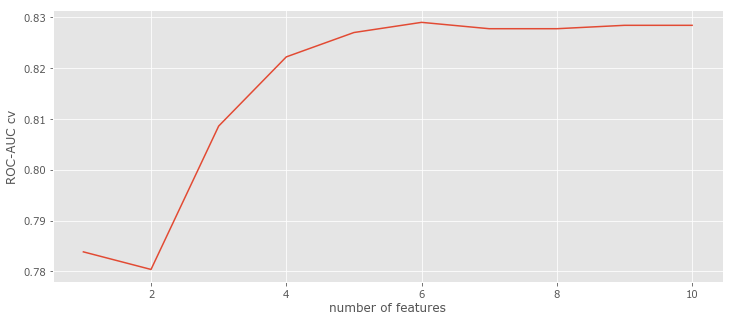

In [59]:
d = rfe.grid_scores_.shape[0]
plt.plot(range(1, d+1), rfe.grid_scores_)
plt.xlabel('number of features')
plt.ylabel('ROC-AUC cv')

In [62]:
print 'Выбранные признаки'
fnames = df_prep.columns[1:].values
fnames[rfe.support_]

Выбранные признаки


array(['Sex', 'Age', 'Parch', 'Pclass=3', 'Embarked=Q', 'Embarked=S'], dtype=object)

In [66]:
pd.Series(index=fnames[rfe.support_], data=rfe.estimator_.coef_[0])

Sex           2.372815
Age          -0.554682
Parch        -0.243279
Pclass=3     -0.931482
Embarked=Q   -0.329946
Embarked=S   -0.338861
dtype: float64

### Embedded methods

* Обучите случайный лес на данных
* Выведите важность признаков и сравните с выдачей по Filter и Wrapper подходам

In [ ]:
## Your code here

# Principal Component Analysis
## Метод Главных Компонент

# PCA

* Позволяет уменьшить число переменных, выбрав самые изменчивые из них
* Новые переменные являются линейной комбинацией старых переменных
* Переход к ортономированному базису

<center><img src='http://www.visiondummy.com/wp-content/uploads/2014/05/correlated_2d.png' width=600></center>

## FYI (Посмотрите дома, если интересно)

### Построение PCA
*  Пусть $x \in \mathbb{R}^d$ - вектор признаков для какого-то объекта. Будем считать, что $x$ - центрировано и отшкалировано. $E[x_i] = 0, V[x_i] = 1, \quad i=1 \dots d$
* Требуется найти линейное преобразование, которое задается ортогональной матрицей $A$:
$$ pc = A^\top x $$

* $pc_i = a_i^\top x = x^\top a_i$
* $cov[x] = E[(x - E[x])(x - E[x])^\top] = Exx^\top = \Sigma$ -  ковариационная матрица

* $E[pc_i] = E[a_i^\top x] = a_i^\top E[x]$
* $cov[pc_i, pc_j] = E[pc_i \cdot pc_j^\top] = a_i^\top \Sigma a_j $
* $\Sigma$ - симметричная и положительно определенная матрица.
    * Собственные числа $\lambda_i \in \mathbb{R}, \lambda_i \geq 0$ (Будем считать, что $\lambda_1 > \lambda_2  > \dots > \lambda_d $
    * Собственные вектора при $\lambda_i \neq \lambda_j $ ортогональны: $v_i^\top v_j = 0$
    * У каждого $\lambda_i$ есть единственный $v_i$

### Первая компонента
$$ pc_1 = a_1 ^\top x $$

\begin{equation}
\begin{cases}
V[pc_1] = a_1^\top \Sigma a_1 \rightarrow \max_a \\
a_1^\top a_1 = 1
\end{cases}
\end{equation}
* Строим функцию лагранжа
$$ \mathcal{L}(a_1, \nu) = a_1^\top \Sigma a_1 - \nu (a_1^\top a_1 - 1) \rightarrow max_{a_1, \nu}$$
* Считаем производую по $a_1$
$$ \frac{\partial\mathcal{L}}{\partial a_1} = 2\Sigma a_1 - 2\nu a_1 = 0 $$
* Получается, что $a_1$ один из собственных векторов матрицы $\Sigma$, причем при $\lambda_1$
$$ V[pc_1] = a_1^\top \Sigma a_1 = \lambda_i a_1^\top a_1 = \lambda_i $$

### Вторая компонента
$$ pc_2 = a_2 ^\top x $$

\begin{equation}
\begin{cases}
V[pc_1] = a_2^\top \Sigma a_2 \rightarrow \max_a \\
a_2^\top a_2 = 1 \\
cov[pc_1, pc_2] = a_2^\top \Sigma a_1 = \lambda_1 a_2^\top a_1 = 0
\end{cases}
\end{equation}
* Строим функцию лагранжа
$$ \mathcal{L}(a_2, \nu, \tau) = a_2^\top \Sigma a_2 - \nu (a_2^\top a_2 - 1) - \tau a_2^\top a_1 \rightarrow max_{a_1, \nu}$$

Аналогичными выкладками приходим к тому, что $a_2$ - собственный вектор $\Sigma$ при $\lambda_2$

## Singular Value Decomposition

Для любой матрицы $X$ размера $n \times m$ можно найти разложение вида:
$$ X = U S V^\top ,$$
где 
* $U$ - унитарная матрица, состоящая из собственных векторов $XX^\top$
* $V$ - унитарная матрица, состоящая из собственных векторов $X^\top X$
* $S$ - диагональная матрица с сингулярными числами $s_i = \sqrt{\lambda_i}$

Матрицы $U$ и $V$ ортогональны и могут быть использованы для перехода к ортогональному базису:
$$ XV = US$$

Сокращение размерности заключается в том, что вместо того, чтобы умножать $X$ на всю матрицу $V$, а лишь на первые $k<m$ её столбцов - матрицу $V'$

Квадраты сингулярных чисел в $S$ содержат дисперсию, объясненную в главных компонентах

## MNIST
<center><img src='https://habrastorage.org/files/cca/f67/7de/ccaf677ded5d4028a3095e9bfbd7fa19.png'></center>

## MNIST PCA

<center><img src='http://nikhilbuduma.com/img/autoencoder_digit_exp.png' width=800></center>

## Игрушечный пример

In [ ]:
from sklearn.decomposition import PCA
from numpy.linalg import svd
from sklearn.datasets import load_digits

In [ ]:
C = np.array([[0., -0.7], [1.5, 0.7]])
X = np.dot(np.random.randn(200, 2) + np.array([4, 2]), C)

In [ ]:
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')

In [ ]:
pca = PCA(n_components=2)

In [ ]:
PC = pca.fit_transform(X)

In [ ]:
coef = pca.components_
coef

In [ ]:
m = np.mean(X,axis=0)

fig, ax = plt.subplots(1,2)

ax[0].plot([0, coef[0,0]*2]+m[0], [0, coef[0,1]*2]+m[1],'--k')
ax[0].plot([0, coef[1,0]*2]+m[0], [0, coef[1,1]*2]+m[1],'--k')
ax[0].scatter(X[:,0], X[:,1])
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')

ax[1].scatter(PC[:,0], PC[:,1])
ax[1].set_xlabel('$pc_1$')
ax[1].set_ylabel('$pc_2$')

ax[0].axis('equal')
ax[1].axis('equal')

#### Сделаем все тоже самое через  SVD

In [ ]:
## Your Code Here

## Чиселки

In [ ]:
digits = load_digits()
X = digits.images
y = digits.target

In [ ]:
plt.imshow(X[2,:], cmap='Greys', interpolation='none')

#### Задание
* Переведите изображения к формату "матрица объект-признак" (reshape)
* Выполните PCA c двумя компонентами и изобратите полученные точки на плоскости, раскаживая каждую точку в отдельный цвет в соответствии с `y`
* Отнормируйте данные, запустите SVD, домножте `X` на нужную матрицу и убедитесь, что у вас получается тот же результат

In [ ]:
### Your Code Here

## Пищевая ценность продуктов

* Загрузите набор данных о пищевом рационе в разных странах мира `diet.csv`
* Примените на данных PCA с 2 компонентами
* Изобразите объекты в сжатом пространстве

In [ ]:
df = pd.read_csv('diet.csv', sep=';')

In [ ]:
df = df.dropna(axis=1)
df = df.drop('Energy (kcal/day)', axis=1)
df = df.set_index('Countries')

In [ ]:
df.head()

In [ ]:
X = df.values
X = (X - X.mean(axis=0))/X.std(axis=0)

In [ ]:
## Your Code Here

* Скорее всего вы обнаружите некоторые выбросы, с этим ничего не поделать - PCA чувствителен к выбросам
* Удалите объекты-выборосы и повторите процедуру
* Постарайтесь проинтерпретировать главные компоненты

In [ ]:
## Your Code Here

# Bonus: T-distributed stochastic neighbor embedding

* [Вывод](http://jmlr.csail.mit.edu/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)
* [Примеры](http://lvdmaaten.github.io/tsne/)
* [Демо](http://distill.pub/2016/misread-tsne/)